# Importação de Variáveis e Indicadores

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

btc = pd.read_excel("../wrangled_data/serie_bitcoin.xlsx", index_col = "Data")
variaveis = pd.read_excel("../wrangled_data/variaveis.xlsx", index_col = "Data")

stop_fixo = pd.read_excel("../wrangled_data/stop_fixo.xlsx", index_col = "Data")
stop_vol = pd.read_excel("../wrangled_data/stop_vol.xlsx", index_col = "Data")

# Separação Treinamento - Teste

In [118]:
df = variaveis.join(stop_fixo)

# Período de Treinamento
ini_treino = "2011-02-01"
fim_treino = "2018-12-31"
X_train = variaveis[ini_treino:fim_treino]
y_train = df["Alvo_Binário"][ini_treino:fim_treino]

# Período de Teste
ini_teste = "2019-01-01"
fim_teste = "2021-07-31"
X_test = variaveis[ini_teste:fim_teste]
y_test = df["Alvo_Binário"][ini_teste:fim_teste]

# Análise dos Dados

#### Bitcoin no período de treinamento

In [138]:
import plotly.graph_objects as go

btc_train = np.log(btc[:fim_treino])
fig = go.Figure(data = [go.Candlestick(x = btc_train.index, open = btc_train["Abertura"], high = btc_train["Máxima"],low = btc_train["Mínima"], close = btc_train["Fechamento"])])

fig.update_layout(title = 'Preço Bitcoin - Treinamento (Logaritmizado)', xaxis_rangeslider_visible=False)

fig.show()

#### Distribuição dos Retornos do Bitcoin

<AxesSubplot:title={'center':'Retornos - Treinamento'}, xlabel='Data'>

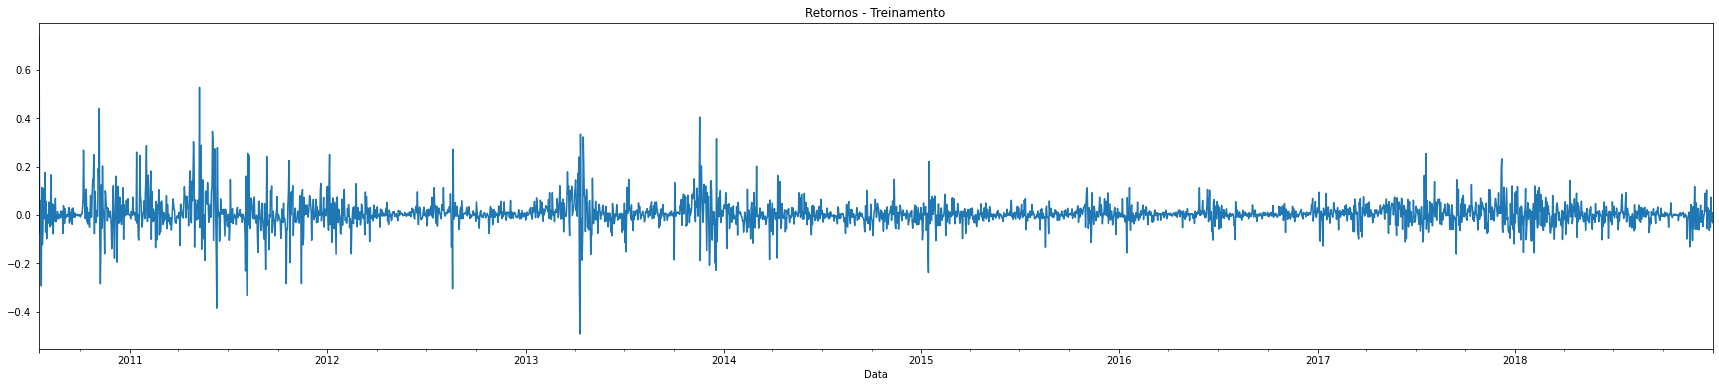

In [139]:
btc["Fechamento"][:fim_treino].pct_change().plot(kind = "line", title = "Retornos - Treinamento", figsize=(30,6))

<AxesSubplot:title={'center':'Retornos - Treinamento'}, ylabel='Frequency'>

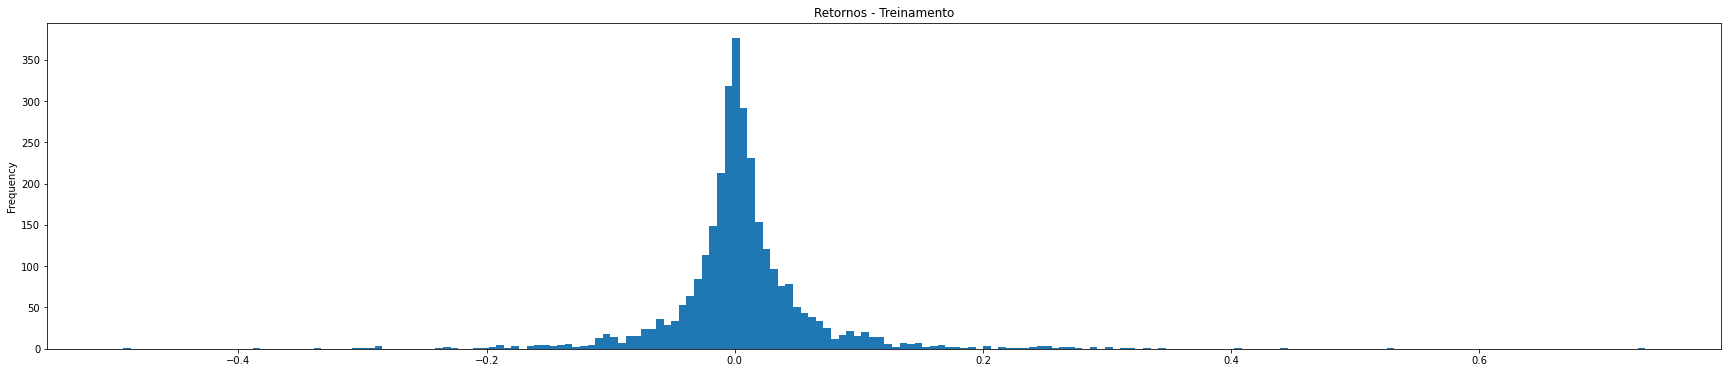

In [140]:
btc["Fechamento"][:fim_treino].pct_change().plot(kind = "hist", title = "Retornos - Treinamento", figsize=(30,6), bins = 200)

#### Multicolinearidade

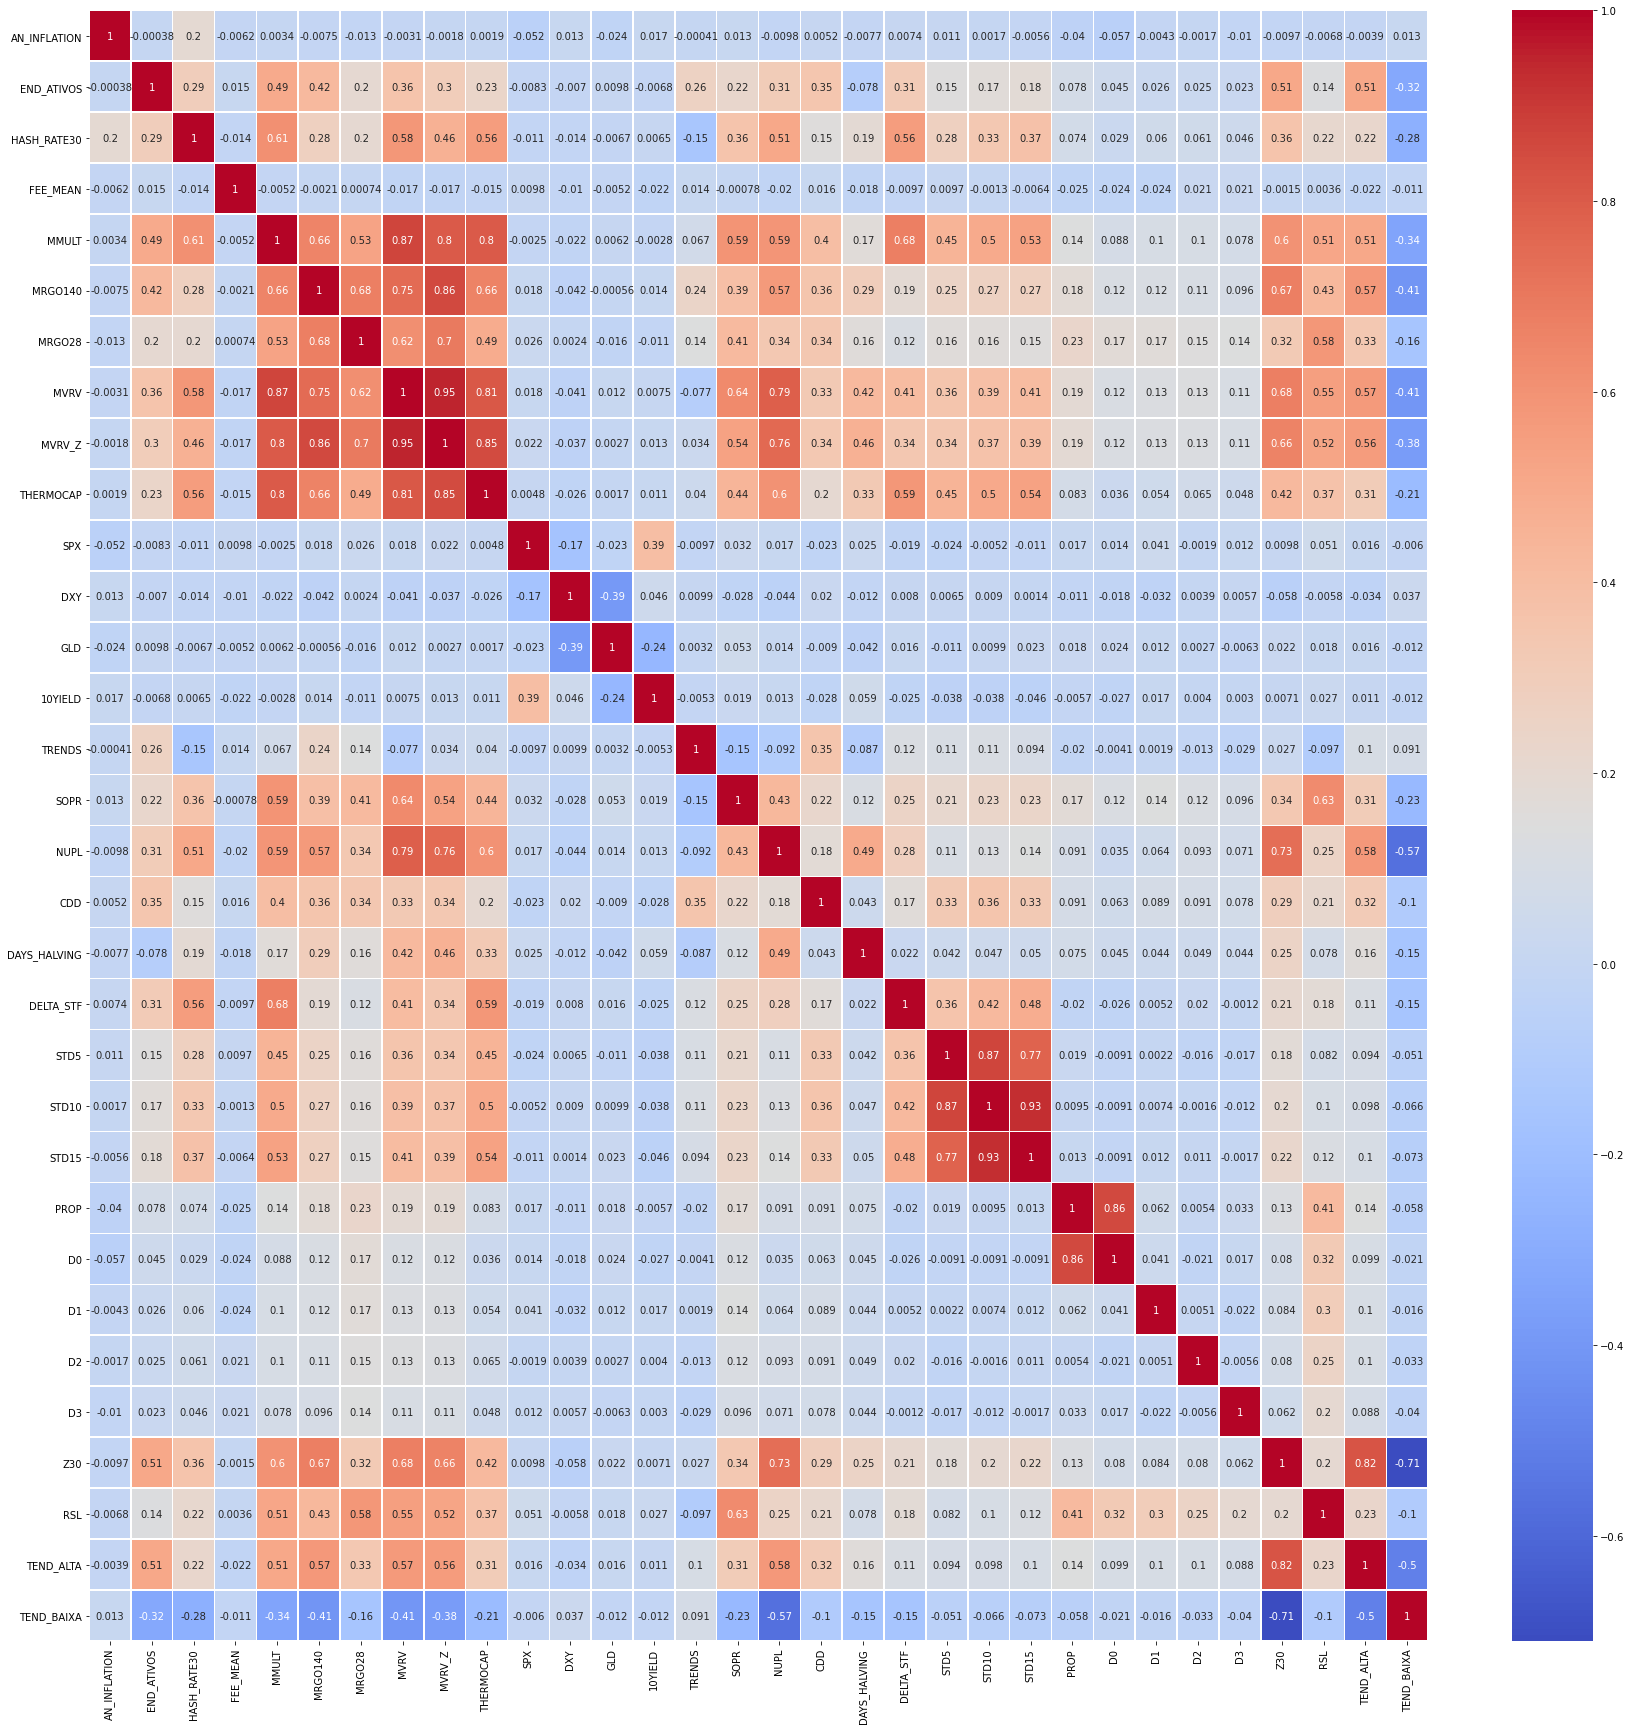

In [141]:
import seaborn as sns
correl_hm = X_train.corr()
fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(correl_hm, cmap = "coolwarm", annot = True, linewidths = .6, ax = ax);

#### Relação Individual Variável-Alvo

In [123]:
df.corr()['Alvo_Contínuo'].drop(['Alvo_Binário', "Alvo_Contínuo", "Stop_Long", "Stop_Short", "Retorno"]).abs().sort_values(ascending = False)

MVRV            0.109784
SOPR            0.108633
PROP            0.085090
RSL             0.081056
STD10           0.078866
MVRV_Z          0.078694
D0              0.077790
TEND_ALTA       0.076879
STD5            0.076557
MMULT           0.074938
STD15           0.073218
MRGO28          0.071515
Z30             0.063361
HASH_RATE30     0.060626
CDD             0.059659
MRGO140         0.054076
GLD             0.046623
TRENDS          0.045607
END_ATIVOS      0.043786
D1              0.033734
D3              0.030413
NUPL            0.029326
THERMOCAP       0.029265
DELTA_STF       0.027768
D2              0.020660
DAYS_HALVING    0.019433
TEND_BAIXA      0.014281
AN_INFLATION    0.008510
SPX             0.008361
DXY             0.007475
FEE_MEAN        0.003490
10YIELD         0.001493
Name: Alvo_Contínuo, dtype: float64

# Modelagem

In [124]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import GridSearchCV

### Otimização

Hiperparâmetros a serem otimizados:

* hidden_layer_sizes -> tupla contendo o número de neurônios dentro de cada camada (padrão: uma camada de 100 neurons)
* max_iter -> número máximo de iterações a serem realizadas pelo método de backpropagation
* alpha -> o valor máximo de alteração dos coeficientes em cada iteração, para minimizar a função de custo (padrão: 0.0001)
* solver -> Algoritmo utilizado para encontrar a solução ótima, cujo tempo de obtenção da resposta varia. Opções: 'lbfgs', 'sgd' e 'adam'.

#### Treinamento

In [151]:
# modelo = MLPClassifier(max_iter = 100, random_state = 42)

# parametros = {'hidden_layer_sizes': [(50,50), (50,100,50), (100,)],
#               'activation': ['tanh', 'relu'],
#               'solver': ['sgd', 'adam', "lbfgs"],
#               'alpha': [0.0001, 0.05],
#               'learning_rate': ['constant','adaptive'],
#               'max_iter': [5, 15, 25, 50, 100]}

# melhor_modelo = GridSearchCV(modelo, parametros, n_jobs = -1, cv = 10, scoring = "roc_auc")
# melhor_modelo.fit(X_train, y_train)

# print('Melhor conjunto de parâmetros:\n', melhor_modelo.best_params_)

In [152]:
# Para não ter que rodar novamente...
melhor_modelo = MLPClassifier(activation = "relu", alpha = 0.05, hidden_layer_sizes = (50, 50), learning_rate = "constant", max_iter = 5, solver = "adam", verbose = True, random_state = 42)
melhor_modelo.fit(X_train, y_train)

Iteration 1, loss = 4.88701436
Iteration 2, loss = 1.59965301
Iteration 3, loss = 0.97755497
Iteration 4, loss = 0.86130264
Iteration 5, loss = 0.76817155


C:\Users\Bruno Marcelino\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.



MLPClassifier(alpha=0.05, hidden_layer_sizes=(50, 50), max_iter=5,
              random_state=42, verbose=True)

#### Teste

<AxesSubplot:title={'center':'Probabilidades'}>

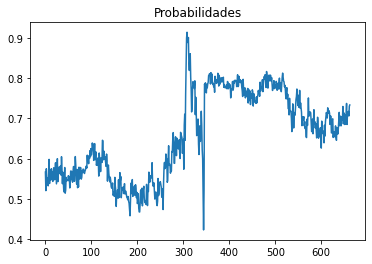

In [153]:
y_pred_train = melhor_modelo.predict(X_train)
y_pred_test = melhor_modelo.predict(X_test)

y_proba_train = melhor_modelo.predict_proba(X_train)[:,1]
y_proba_test = melhor_modelo.predict_proba(X_test)[:,1]
pd.Series(y_pred_proba).plot(title = "Probabilidades")

#### Avaliação

In [154]:
# Treinamento
print(confusion_matrix(y_train, y_pred_train))
print()
print(accuracy_score(y_train, y_pred_train))
print()
print(classification_report(y_train, y_pred_train))

[[   5  916]
 [   4 1114]]

0.5487984306032369

              precision    recall  f1-score   support

           0       0.56      0.01      0.01       921
           1       0.55      1.00      0.71      1118

    accuracy                           0.55      2039
   macro avg       0.55      0.50      0.36      2039
weighted avg       0.55      0.55      0.39      2039



In [155]:
# Teste
print(confusion_matrix(y_test, y_pred))
print()
print(accuracy_score(y_test, y_pred))
print()
print(classification_report(y_test, y_pred))

[[ 19 287]
 [  7 350]]

0.5565610859728507

              precision    recall  f1-score   support

           0       0.73      0.06      0.11       306
           1       0.55      0.98      0.70       357

    accuracy                           0.56       663
   macro avg       0.64      0.52      0.41       663
weighted avg       0.63      0.56      0.43       663



AUC - Teste : 0.5277823547719742


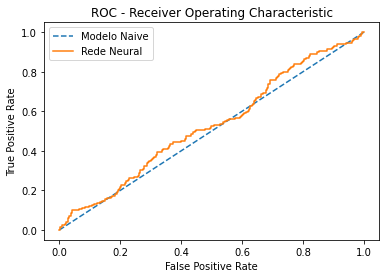

In [156]:
# Calculando a AUC (Area Under the Curve)
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)
roc_auc = auc(fpr, tpr)
print("AUC - Teste :", roc_auc)

# Criando Curva ROC
plt.plot([0,1], [0,1], linestyle = '--', label = 'Modelo Naive')
plt.plot(fpr, tpr, label = 'Rede Neural')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC - Receiver Operating Characteristic")
plt.legend()
plt.show()

#### Sinais

In [157]:
y_proba_train

array([0.9245763 , 0.92708427, 0.92210591, ..., 0.64309525, 0.70220251,
       0.65038429])

In [158]:
n_q = 100

sinais = pd.DataFrame()
sinais["Observado"] = np.array(y_train)
sinais["Probabilidades"] = pd.Series(y_proba_train)
sinais["Quantil"] = pd.qcut(sinais["Probabilidades"], n_q, False)
sinais["Intervalo_Quantil"] = pd.qcut(sinais["Probabilidades"], n_q)

##### Automatização do Ponto de Corte 1:

In [159]:
# Automatização 1 (não funciona de maneira adequada pois os quantis são desordenados)

# quantis = pd.DataFrame()
# quantis["Compra"] = sinais[sinais["Observado"] == 0]["Quantil"].value_counts(sort = True)
# quantis["Venda"] = sinais[sinais["Observado"] == 1]["Quantil"].value_counts(sort = True)
# quantis = quantis.reset_index().rename(columns = {"index" : "Quantil"})

#quantis["Indecisão Compra"] = np.where(quantis["Compra"] < quantis["Venda"], 1, 0)
#quantis["Indecisão Venda"] = np.where(quantis["Compra"] > quantis["Venda"], 1, 0)

#lim_venda = quantis[quantis["Indecisão Venda"] == 1]["Quantil"].max()
#lim_compra = quantis[quantis["Indecisão Compra"] == 1]["Quantil"].min()

# lim_venda = 6 # limite superior
# lim_compra = 11 # limite inferior

# corte_compra = sinais[sinais["Quantil"] == lim_compra]["Intervalo_Quantil"].iloc[0].left
# corte_venda = sinais[sinais["Quantil"] == lim_venda]["Intervalo_Quantil"].iloc[0].right

# print("Probabilidades de corte:", corte_venda, corte_compra)
# print("Quantis:", lim_venda, lim_compra)

# sinais.head()

##### Automatização do Ponto de Corte 2:

In [160]:
# Automatização 2:
pares = []
for i in range(n_q):
    for j in range(n_q):
        if i < j:
            pares.append((i,j))
            
def backtest(par):

    lim_venda = par[0]
    lim_compra = par[1]
    
    corte_compra = sinais[sinais["Quantil"] == lim_compra]["Intervalo_Quantil"].iloc[0].left
    corte_venda = sinais[sinais["Quantil"] == lim_venda]["Intervalo_Quantil"].iloc[0].right
    
    resultado = pd.DataFrame()
    resultado["Observado"] = np.array(y_train)
    resultado["Probabilidades"] = pd.Series(y_proba_train)
    resultado["Operação"] = np.where(resultado["Probabilidades"] > corte_compra, 1, np.where(resultado["Probabilidades"] < corte_venda, -1, 0))

    bt = pd.DataFrame()
    bt["Alvo"] = df["Alvo_Contínuo"][ini_treino:fim_treino].reset_index(drop = True)
    bt["Sinal"] = resultado["Operação"]
    bt.index = df["Alvo_Contínuo"][ini_treino:fim_treino].index
    bt["Retorno Diário"] = np.where(bt["Sinal"] == 1, bt["Alvo"], np.where(bt["Sinal"] == -1, bt["Alvo"], 0))
    bt["Retorno Acumulado"] = (bt["Retorno Diário"] + 1).cumprod()

    return bt.tail(1)["Retorno Acumulado"].values

retornos = []
for i in pares:
    retornos.append(backtest(i))
    
print("Maior retorno no treinamento:", max(retornos))
print("Quantis de Corte", pares[retornos.index(max(retornos))])

lim_compra = pares[retornos.index(max(retornos))][1]
lim_venda = pares[retornos.index(max(retornos))][0]

corte_compra = sinais[sinais["Quantil"] == lim_compra]["Intervalo_Quantil"].iloc[0].left
corte_venda = sinais[sinais["Quantil"] == lim_venda]["Intervalo_Quantil"].iloc[0].right

Maior retorno no treinamento: [5939.87086318]
Quantis de Corte (33, 61)


#### Backtest

Retorno BH: [368.67672704] %
Retorno do Modelo: [901.87522521] %


<AxesSubplot:xlabel='Data'>

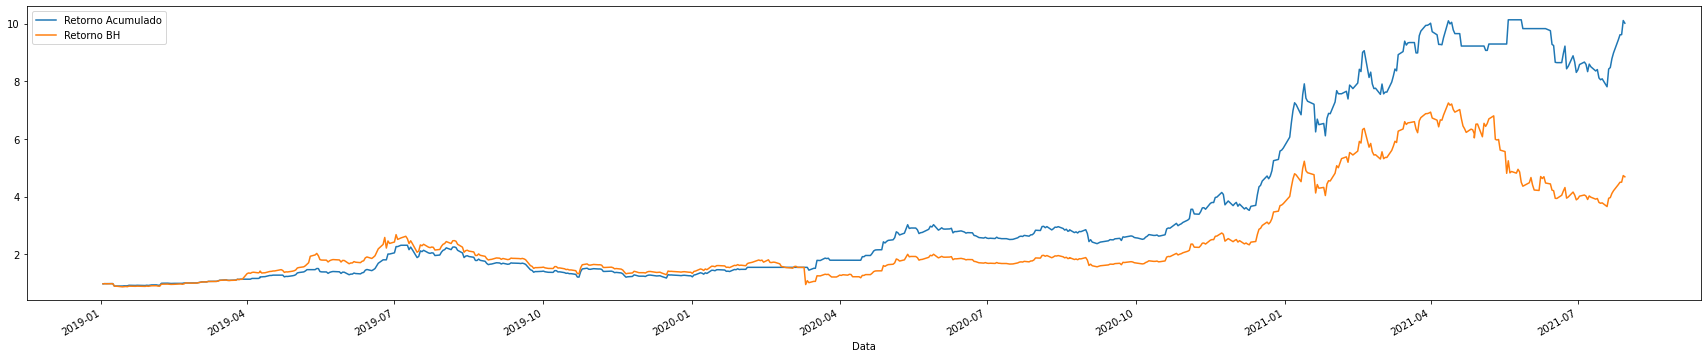

In [161]:
resultado = pd.DataFrame()
resultado["Observado"] = np.array(y_test)
resultado["Probabilidades"] = pd.Series(y_proba_test)
resultado["Operação"] = np.where(resultado["Probabilidades"] > corte_compra, 1, np.where(resultado["Probabilidades"] < corte_venda, -1, 0))
resultado["Operação"].value_counts()

bt = pd.DataFrame()
bt["Alvo"] = df["Alvo_Contínuo"][ini_teste:fim_teste].reset_index(drop = True)
bt["Sinal"] = resultado["Operação"]
bt.index = df["Alvo_Contínuo"][ini_teste:fim_teste].index

bt["Retorno Diário"] = np.where(bt["Sinal"] == 1, bt["Alvo"], np.where(bt["Sinal"] == -1, bt["Alvo"], 0))

bt["Retorno Acumulado"] = (bt["Retorno Diário"] + 1).cumprod()
bt["Retorno BH"] = (bt["Alvo"] + 1).cumprod()

print("Retorno BH:", (bt.tail(1)["Retorno BH"].values-1)*100, "%")
print("Retorno do Modelo:", (bt.tail(1)["Retorno Acumulado"].values-1)*100, "%")

bt[["Retorno Acumulado", "Retorno BH"]].plot(figsize=(30,6))

In [162]:
# Acrescentando Stop
# stop = 0.3
# bt = bt.join(df[["Stop_Long", "Stop_Short"]])
# bt["Retorno Long"] = np.where(bt["Sinal"] == 1, bt["Alvo"], 0)
# bt["Retorno Short"] = np.where(bt["Sinal"] == -1, -bt["Alvo"], 0)
# # bt["Retorno Long"] = np.where(bt["Stop_Long"] == 1, -stop, bt["Retorno Long"])
# # bt["Retorno Short"] = np.where(bt["Stop_Short"] == 1, -stop, bt["Retorno Short"])
# bt["Retorno Diário"] = bt["Retorno Long"] + bt["Retorno Short"]